In [1]:
# install nltk and download language packages
!python3 -m nltk.downloader wordnet punkt averaged_perceptron_tagger

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import KFold, train_test_split
from util import load_json, dump_json

seed = 17

In [3]:
# text processing and cleanup
!python3 preprocess_data.py -a output.txt -o data.json

868it [00:09, 89.93it/s]


In [0]:
candidates = load_json('candidates.json')
candidates = {list(c.keys())[0]:c[list(c.keys())[0]] for c in candidates}
assert len(candidates.keys()) == len(load_json('candidates.json'))
# put data into a pandas
articles = load_json('data.json')
article_properties = list(sorted(articles[0].keys()))
articles_dict = {article_property: [article[article_property] for article in articles] for article_property in article_properties}
articles_df = pd.DataFrame.from_dict(articles_dict)
articles_train_df, articles_test_df = train_test_split(articles_df, test_size=0.25, random_state=17)

In [5]:
articles_df.head()

,abstract,fos,id,references,title,year
0,company diverse industry decide pricing policy...,"[economics, profitability index, microeconomic...",100913566,"[1502705241, 2002741233, 2010497485, 205624824...",Contingent Preannounced Pricing Policies with ...,2016
1,emerge ad hoc cloud form cloud compute paradig...,"[computer science, distribute computing, algeb...",1009626802,"[116648389, 1506342804, 1535487433, 1601098769...",A Distributed Secure Outsourcing Scheme for So...,2017
2,article study univariate bivariate truncate vo...,"[anderson darling test, artificial intelligenc...",101132528,[2135642594],Univariate and bivariate truncated von Mises d...,2017
3,sequence cluster important topic expert data m...,"[fuzzy clustering, correlation cluster, cluste...",1011638332,"[1599310603, 2007370139, 2027499598, 205954804...",Sequence clustering algorithm based on weighte...,2017
4,propose principled approach learn parameter ba...,"[wake sleep algorithm, semi supervise learning...",1013235724,"[162422970, 203049729, 293230287, 1503398984, ...",Learning Bayesian network parameters under equ...,2017


In [0]:
candidates

In [0]:
# count occurrences of words in training data
count_vectorizer = CountVectorizer()
corpus = [article['abstract'] for _, article in articles_train_df.iterrows()]
count_vectorizer.fit(corpus)

# create a dataframe of counts slowly to not fill up the memory
step_size = 1000
count_cols = ['vocab_{}'.format(word) for word in count_vectorizer.get_feature_names()]
counts_df = pd.DataFrame(columns=count_cols)
for i in range(0, len(articles_train_df), step_size):
  corpus = [article['abstract'] for _, article in articles_train_df.iloc[[k for k in range(i, min(i+step_size+1, len(articles_train_df)))]].iterrows()]
  counts = count_vectorizer.transform(corpus)
  step_counts_df = pd.DataFrame(counts.todense(), columns=count_cols)
  counts_df = pd.concat([counts_df, step_counts_df], ignore_index=True).reset_index()

In [8]:
counts_df.shape

(651, 6541)

In [0]:
# add the counts dataframe to training dataframe
train_counts_df = pd.concat([articles_train_df, counts_df], axis=1).reset_index()
train_counts_no_nans_df = train_counts_df[count_cols].fillna(0)

In [0]:
# do the same thing for test, except use the same vectorizer as train
counts_df = pd.DataFrame(columns=count_cols)
for i in range(0, len(articles_test_df), step_size):
  corpus = [article['abstract'] for _, article in articles_test_df.iloc[[k for k in range(i, min(i+step_size+1, len(articles_test_df)))]].iterrows()]
  counts = count_vectorizer.transform(corpus)
  step_counts_df = pd.DataFrame(counts.todense(), columns=count_cols)
  counts_df = pd.concat([counts_df, step_counts_df], ignore_index=True).reset_index()

In [0]:
# add the counts dataframe to test dataframe
test_counts_df = pd.concat([articles_test_df, counts_df], axis=1).reset_index()
test_counts_no_nans_df = test_counts_df[count_cols].fillna(0)

In [12]:
# check for nulls
train_counts_no_nans_df[count_cols].isnull().sum().sum()

0

In [0]:
test_candidates = {paper_id: candidates[paper_id] for paper_id in candidates if paper_id in test_counts_df['id'].tolist()}
train_candidates = {paper_id: candidates[paper_id] for paper_id in candidates if paper_id in train_counts_df['id'].tolist()}

In [14]:
# vocabulary size
len(count_vectorizer.get_feature_names())

6540

In [0]:
train_counts_no_nans_df = train_counts_no_nans_df.reset_index()
test_counts_no_nans_df = test_counts_no_nans_df.reset_index()

In [0]:
# function that will keep score for a given k for top k candidates
def get_test_score(model, train_df, test_df, scores, candidates, top_k=1):
  # check if top_k vectors with highest cosine similarity have one of the cited papers
  score = 0
  num_examples = len(test_df)
  score_indices = np.argsort(scores, axis=1)
  for i, (_, row) in enumerate(test_df.iterrows()):
    if row['id'] in candidates:
      candidate_indices = train_df.index[train_df['id'].isin(candidates[row['id']])].tolist()
      candidates_df = train_df.iloc[candidate_indices]
      candidate_scores = scores[i, candidate_indices]
      top_k_candidate_scores_indices = np.argsort(candidate_scores)[::-1][:top_k]
      top_k_ids = candidates_df.iloc[top_k_candidate_scores_indices]['id'].tolist()
      if any(citation_id in top_k_ids for citation_id in row['references']):
        score += 1
      elif not any(candidates_df['id'].isin(row['references'])):
        # none of the candidates were valid
        # invalid example
        num_examples -= 1
    else:
      # current paper is not in the candidates
      # invalid example
      num_examples -= 1

  if num_examples == 0:
    return 1

  return score / num_examples

In [17]:
# CV grid search for best n_components
n_splits = 2
kf = KFold(n_splits=n_splits, random_state=seed)
scores = []
base_n_components = 12
for n in range(base_n_components, 15):
  fold_scores = []
  for i, (train_index, test_index) in enumerate(kf.split(train_counts_no_nans_df)):
    train_df = train_counts_no_nans_df.iloc[train_index]
    validate_df = train_counts_no_nans_df.iloc[test_index]
    lda = LatentDirichletAllocation(n_components=n, random_state=seed)
    lda.fit(train_df[count_cols])
    
    X = lda.transform(train_counts_no_nans_df[count_cols])
    X_validate = lda.transform(validate_df[count_cols])
    score = get_test_score(lda, train_counts_df, train_counts_df.iloc[test_index], np.matmul(X_validate, X.T), train_candidates, 1)
    fold_scores += [score]
    print('N:', n, 'Score:', '{}%'.format(score*100))

  scores += [sum(fold_scores) / len(fold_scores)]

# found the best n
best_n_components = base_n_components + scores.index(max(scores))

N: 12 Score: 80.51948051948052%
N: 12 Score: 100%
N: 13 Score: 81.81818181818183%
N: 13 Score: 100%
N: 14 Score: 79.22077922077922%
N: 14 Score: 100%


In [18]:
# evaluate lda
best_lda = LatentDirichletAllocation(n_components=best_n_components, random_state=seed)
best_lda.fit(train_counts_no_nans_df[count_cols])
X_train = best_lda.fit_transform(train_counts_no_nans_df[count_cols])
X_test = best_lda.transform(test_counts_no_nans_df[count_cols])
scores = np.matmul(X_test, X_train.T)
print('Top 1:', '{}%'.format(get_test_score(best_lda, train_counts_df, test_counts_df, np.matmul(X_test, X_train.T), test_candidates, top_k=1)*100))
print('Top 2:', '{}%'.format(get_test_score(best_lda, train_counts_df, test_counts_df, np.matmul(X_test, X_train.T), test_candidates, top_k=2)*100))
print('Top 3:', '{}%'.format(get_test_score(best_lda, train_counts_df, test_counts_df, np.matmul(X_test, X_train.T), test_candidates, top_k=3)*100))

Top 1: 72.22222222222221%
Top 2: 72.22222222222221%
Top 3: 94.44444444444444%


In [0]:
def plot_precision_recall(model, train_df, test_df, scores, candidates, max_k=20):
  # check if top_k vectors with highest cosine similarity have one of the cited papers
  k_recall = [0 for _ in range(max_k)]
  k_precision = [0 for _ in range(max_k)]
  num_examples = len(test_df)
  score_indices = np.argsort(scores, axis=1)
  for i, (_, row) in enumerate(test_df.iterrows()):
    if row['id'] in candidates:
      candidate_indices = train_df.index[train_df['id'].isin(candidates[row['id']])].tolist()
      candidates_df = train_df.iloc[candidate_indices]
      candidate_scores = scores[i, candidate_indices]
      top_k_candidate_scores_indices = np.argsort(candidate_scores)[::-1]
      top_k_ids = candidates_df.iloc[top_k_candidate_scores_indices]['id'].tolist()
      
      # calculate recall for this example
      for k, citation_id in enumerate(top_k_ids):
        if citation_id in row['references']:
          for k_key in range(k, max_k):
            k_recall[k_key] += 1
          
          break
      
      # calculate precision for this example
      for k, citation_id in enumerate(top_k_ids):
        if citation_id in row['references']:
          for k_key in range(k, max_k):
            k_precision[k_key] += 1
      
      if not any(candidates_df['id'].isin(row['references'])):
        # none of the candidates were valid
        # invalid example
        num_examples -= 1
    else:
      # current paper is not in the candidates
      # invalid example
      num_examples -= 1

  if num_examples == 0:
    # all examples were invalid
    return

  # plot recall
  k_recall = [k_recall[k] / num_examples for k in range(max_k)]
  plt.title('Recall (y-axis) vs K (x-axis)')
  plt.plot(k_recall, marker='x', color='red')
  plt.xticks([i for i in range(max_k)], [i+1 for i in range(max_k)])
  plt.show()
  
  # plot precision
  k_precision = [k_precision[k] / (k+1) for k in range(max_k)]
  plt.title('Precision (y-axis) vs K (x-axis)')
  plt.plot(k_precision, marker='+', color='green')
  plt.xticks([i for i in range(max_k)], [i+1 for i in range(max_k)])
  plt.show()

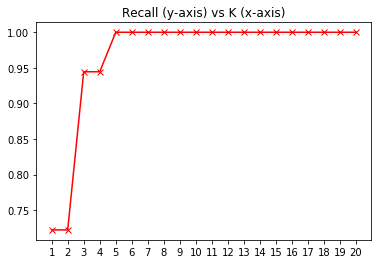

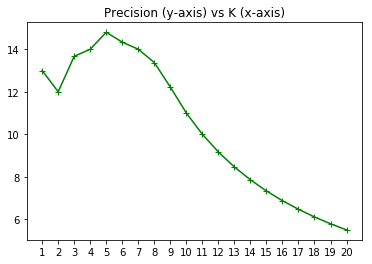

In [20]:
plot_precision_recall(best_lda, train_counts_df, test_counts_df, np.matmul(X_test, X_train.T), test_candidates)